<a href="https://colab.research.google.com/github/tap-o-chek/Neurons_labs/blob/develop/Neuron_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4

Жиделёва София - БИВТ-20-4

# загрузим датасет



In [31]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from datasets import load_dataset
dataset = load_dataset('sasha/dog-food')

  0%|          | 0/2 [00:00<?, ?it/s]

# просмотрим/опишем датасет

In [33]:
labels = dataset["test"].features
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 image
1 label


In [34]:
train_example = dataset['train'][6]
test_example = dataset['test'][6]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 900
    })
})

In [36]:
train_example['label']

0

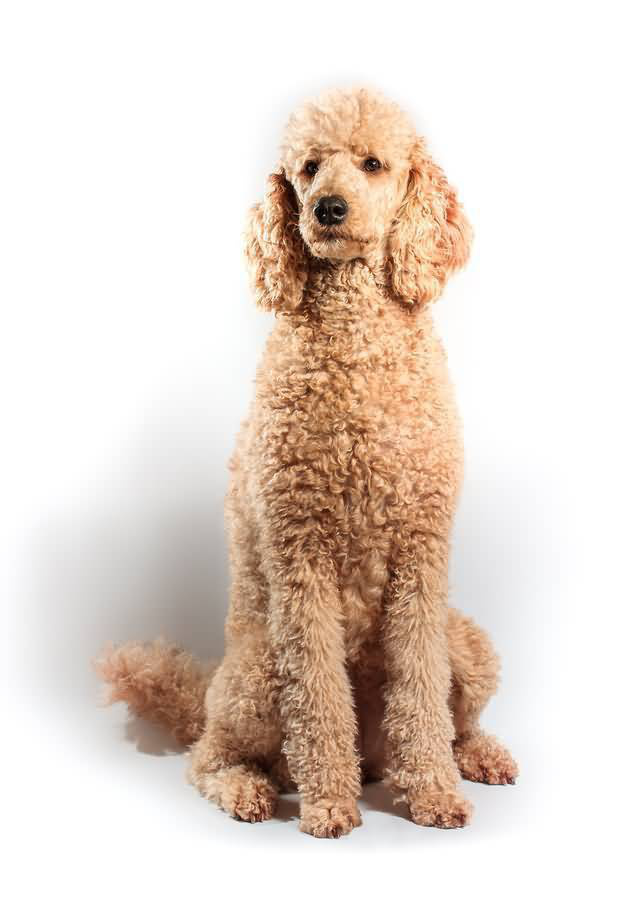

In [37]:
train_example['image']

### В датасете 'sasha/dog-food' 2100 тренировочных наборов данных и 900 тестовых. Наполнение наборов состоит из изображений собак и еды, а также подписи (label) к ним.

### После обучения нейросеть должна будет уметь отличать собак от разного вида еды




# датасет в виде объекта класса Dataset из PyTorch

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms

In [39]:
class IsItDogOrFood(torch.utils.data.Dataset):

  def __init__(self, dataset):
        
      self.dataset = dataset
      
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

  def __len__(self):
      return len(self.dataset)
    
  def get_images(self, index):
      return self.transform(self.dataset[index]['image'])
  
  def get_labels(self, index):
      return self.dataset[index]['label']
  
  def __getitem__(self, index):
      train_images = self.get_images(index)
      train_labels = self.get_labels(index)
      return train_images, train_labels

In [40]:
train_dataset = IsItDogOrFood(dataset["train"])
test_dataset = IsItDogOrFood(dataset["test"])

# датасет в Dataloader

In [41]:
from torch.utils.data import DataLoader

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
class_names = dataset["test"].features["label"].names
dataset_size = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #выбираем среду

# видуальный вывод датасета




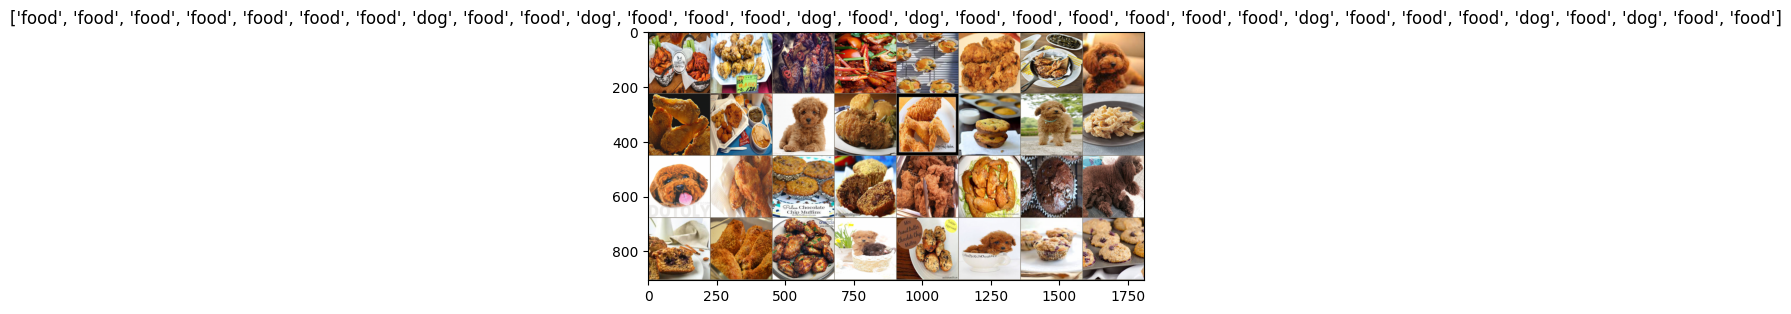

In [44]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # транспонировка для масштаба
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


input, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(input)

imshow(out, title=[class_names[x] for x in classes])

# нейросеть


In [45]:
def train_model(model, criterion, optimizer, scheduler, epochs=10):
    # начинаю отсчёт времени
    start_timer = time.time() 

    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            
            if phase == 'train':
                scheduler.step()


            if phase == 'train':
                model.train()
            else:
                model.eval()  # evaluation mode

            current_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for input, labels in current_dataloader:
                input = input.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * input.size(0)
                running_corrects += torch.sum(predictions == labels.data)


            epoch_loss = current_loss / dataset_size[phase]
            epoch_accuracy = running_corrects.double() / dataset_size[phase]


            if (epoch_accuracy > best_accuracy):
                best_accuracy = epoch_accuracy
                best_weights = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} | Accurancy: {:.4f}'
                .format(phase, epoch_loss, epoch_accuracy))

        print()

    # вывод времени выполнения
    time_elapsed = time.time() - start_timer
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # загрузка собранных лучших весов для модели
    model.load_state_dict(best_weights)
    return model

In [46]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(64),

    nn.Flatten(),

    nn.Linear(576, 32),
    nn.Linear(32, 2),
)


model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, epochs=10)

Epoch [1/10]
----------
train Loss: 1.5523 | Accurancy: 0.7024
test Loss: 1.5261 | Accurancy: 0.6633

Epoch [2/10]
----------
train Loss: 0.8909 | Accurancy: 0.7419
test Loss: 0.6340 | Accurancy: 0.7533

Epoch [3/10]
----------
train Loss: 0.4249 | Accurancy: 0.8181
test Loss: 0.3632 | Accurancy: 0.8378

Epoch [4/10]
----------
train Loss: 0.3822 | Accurancy: 0.8281
test Loss: 0.3413 | Accurancy: 0.8744

Epoch [5/10]
----------
train Loss: 0.3778 | Accurancy: 0.8362
test Loss: 0.3307 | Accurancy: 0.8733

Epoch [6/10]
----------
train Loss: 0.3587 | Accurancy: 0.8414
test Loss: 0.3260 | Accurancy: 0.8744

Epoch [7/10]
----------
train Loss: 0.3599 | Accurancy: 0.8457
test Loss: 0.3247 | Accurancy: 0.8767

Epoch [8/10]
----------
train Loss: 0.3646 | Accurancy: 0.8376
test Loss: 0.3338 | Accurancy: 0.8778

Epoch [9/10]
----------
train Loss: 0.3592 | Accurancy: 0.8429
test Loss: 0.3304 | Accurancy: 0.8789

Epoch [10/10]
----------
train Loss: 0.3543 | Accurancy: 0.8448
test Loss: 0.3264 

# результаты обучения


In [47]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [48]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (input, labels) in enumerate(test_dataloader):
            input = input.to(device)

            outputs = model(input)
            _, predictions = torch.max(outputs, 1)

            for j in range(input.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[j]]))
                imshow(input.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

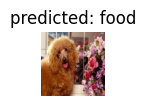

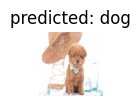

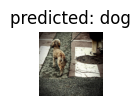

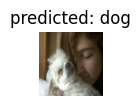

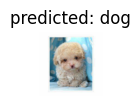

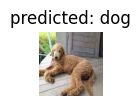

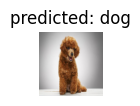

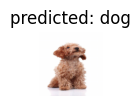

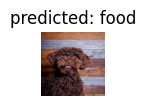

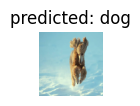

In [49]:
visualize_model(model_fitted, 10)

# Обучение с Transfer Learning
использую ResNet101

In [50]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=10)

Epoch [1/10]
----------
train Loss: 0.1078 | Accurancy: 0.9700
test Loss: 0.0075 | Accurancy: 1.0000

Epoch [2/10]
----------
train Loss: 0.0133 | Accurancy: 0.9990
test Loss: 0.0071 | Accurancy: 0.9989

Epoch [3/10]
----------
train Loss: 0.0133 | Accurancy: 0.9995
test Loss: 0.0075 | Accurancy: 1.0000

Epoch [4/10]
----------
train Loss: 0.0118 | Accurancy: 0.9981
test Loss: 0.0076 | Accurancy: 0.9989

Epoch [5/10]
----------
train Loss: 0.0111 | Accurancy: 0.9986
test Loss: 0.0077 | Accurancy: 1.0000

Epoch [6/10]
----------
train Loss: 0.0086 | Accurancy: 1.0000
test Loss: 0.0073 | Accurancy: 0.9989

Epoch [7/10]
----------
train Loss: 0.0109 | Accurancy: 0.9990
test Loss: 0.0073 | Accurancy: 0.9989

Epoch [8/10]
----------
train Loss: 0.0121 | Accurancy: 0.9995
test Loss: 0.0086 | Accurancy: 1.0000

Epoch [9/10]
----------
train Loss: 0.0097 | Accurancy: 0.9990
test Loss: 0.0076 | Accurancy: 1.0000

Epoch [10/10]
----------
train Loss: 0.0124 | Accurancy: 0.9990
test Loss: 0.0070 

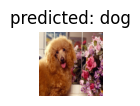

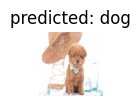

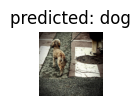

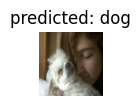

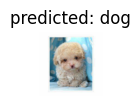

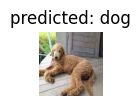

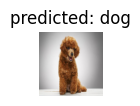

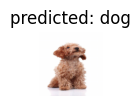

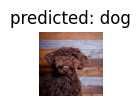

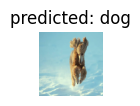

In [52]:
visualize_model(model_ft)

# в итоге имеем

Значения моей модели после обучения:
- train Loss: 0.3543 | Accurancy: 0.8448
- test Loss: 0.3264 | Accurancy: 0.8778
- Best val Acc: 0.878889

Это достаточно хорошая точность для такого довольно небольшого набора данных

Результаты после Transfer Learning на ResNet101:
- train Loss: 0.0124 | Accurancy: 0.9990
- test Loss: 0.0070 | Accurancy: 0.9989
- Best val Acc: 1.000000

Модель показала результаты еще лучше.

В результате обучения модель прекрасно распознаёт собак на изображениях и отличает от еды. ура)